## Direct vs Indirect Effects of Monetary

Consider the very simple Heterogeneous Agent Model: 

\begin{align*}
\max_{c_{it}}\ &  \mathbb{E_0}\ \sum_{t=0}^\infty\ \beta^t\ \dfrac{c_{it}^{1-\sigma}}{1-\sigma} 
\\
c_{it} + a_{it} &= (1 + r_t)a_{it-1} + Y_t s_{it} 
\\
a &\geq \underline{a}
\end{align*}

with market clearing: 

$$ 
C_t \equiv \int c_{it} di = Y_t
$$

and

$$ 
A_t \equiv \int a_{it} di = 0
$$

This implies the following fixed point:

$$
\mathcal{C}_t(\{r_s, Y_s\}) = Y_t.
$$

We will consider a "demand-driven" (as if prices were fully fixed). In this case, a shock in the sequence of interest rate $\{r_s\}$ will require a change in aggregate output $Y_t$.

As in the IKC model, the linearized response of output implies:

$$
d \mathbb{Y} = \underbrace{\mathbb{M}^r d \mathbb{r}}_{\text{direct effects}} + \underbrace{\mathbb{M} d \mathbb{Y}}_{\text{indirect effects}},
$$

where $\mathbb{M}^r \equiv \partial \mathcal{C}_t / \partial r_s $ is the jacobian capturing the direct effect of the interest rate on $\mathcal{C}$.

Let's decompose the direct and indirect effect of a shock in $r$ in different models: HA, HA-zero liquidity, RA.




In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import solved, simple, create_model, hetblocks          # functions
from sequence_jacobian import interpolate, grids, misc, JacobianDict   # modules
import sequence_jacobian as sj  


# Plot parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 12})

Let's first define our simple heterogeneous agent model. We will use the hetblock and the make grids pre-build functions. 

In [2]:
hh = hetblocks.hh_sim.hh
print(f'Inputs: {hh.inputs}\n') # simple household block  with inelastic labor supply 

make_grids = hetblocks.hh_sim.make_grids # note that this function is the same as we used below
help(make_grids) 

#def make_grid(rho_e, sd_e, nE, amin, amax, nA):
#    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
#    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
#    return e_grid, pi_e, Pi, a_grid

# simple post-tax labor income
def income(Y, e_grid):
    y = Y * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])
print(household_simple.inputs)
#print('Micro outputs: ', hh.internals)
#print('Outputs: ', hh.outputs)


Inputs: ['a_grid', 'y', 'r', 'beta', 'eis', 'Pi']

Help on function make_grids in module sequence_jacobian.hetblocks.hh_sim:

make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a)

['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Y']



In addition, we have two simple blocks. One is the usual market clearing, and the other takes us from the exogenous, ex-ante `r` set by monetary policy to the (ex-post) `r` faced by households. Note that we do not actually need the "ex_post_rate" block in this simple experiment, but it allow us to introduce other elements, such as valuation effects (see Auclert AER paper).

In [3]:
@simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

ha_simple = create_model([household_simple, ex_post_rate, mkt_clearing_simple])
print('Inputs:', ha_simple.inputs)
print('Outputs:', ha_simple.outputs)

Inputs: ['beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Y', 'r_ante']
Outputs: ['A', 'C', 'r', 'asset_mkt', 'goods_mkt']


Note we fix the interest rate and output in the steady state and calibrate $\beta$ to get asset market clearing. 

In [4]:
calibration = {'eis': 0.5,     # EIS
               'rho_e': 0.92,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,   # Standard deviation of idiosyncratic productivity shocks
               'Y': 1.,        # Output
               'r_ante': 0.01, # target real interest rate
               'min_a': -1,    # Minimum asset level on the grid
               'max_a': 1_000, # Maximum asset level on the grid
               'n_a': 500,     # Number of asset grid points
               'n_e': 11}      # Number of productivity grid points

# Note that we are fixing Y and choosing Beta such that the asset market clears
ss_ha = ha_simple.solve_steady_state(calibration, {'beta': (0.75, 0.9)}, ['asset_mkt'])
ss_ha.toplevel

{'eis': 0.5,
 'rho_e': 0.92,
 'sd_e': 0.92,
 'Y': 1.0,
 'r_ante': 0.01,
 'min_a': -1,
 'max_a': 1000,
 'n_a': 500,
 'n_e': 11,
 'beta': 0.823354842513158,
 'r': 0.01,
 'A': 6.556095943910378e-12,
 'C': 1.0000000000007718,
 'asset_mkt': 6.556095943910378e-12,
 'goods_mkt': 7.718270467194088e-13}

Now, we build other models. The RA version of our simple model and the HA but calibrated to have zero liquidity (i.e., $\underline{a} = 0$). We write everything in the models dictionary "models", as well as their steady state. 

In [5]:
## ========== Other models for comparison
models = {} # create dictionary with models
models['ha'] = ha_simple
ss = {} # create dictionary with steady state of models
ss['ha'] = ss_ha

## ========== Representative Agent
# Solved model are mini models inside a larger model
@solved(unknowns={'C': 1, 'A': 1}, targets=["euler", "budget_constraint"], solver="broyden_custom")
def household_ra_simple(C, A, Y, eis, beta, r):
    euler = (beta * (1 + r(1))) ** (-eis) * C(1) - C
    budget_constraint = (1 + r) * A(-1) + Y - C - A
    return euler, budget_constraint

models['ra'] = sj.create_model([household_ra_simple, ex_post_rate, mkt_clearing_simple], name="Representative Agent Model")
calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r_ante']) # Different interest rate
ss['ra'] = models['ra'].solve_steady_state(calibration_ra, {'C': 1., 'A': 0.8}, {'budget_constraint': 0., 'asset_mkt': 0.},
                                           dissolve=['household_ra_simple'])

## ========== Zero Liquidity model (amin = 0)
models['ha_zl'] = ha_simple  # Same structure, but different calibration
calibration_zl = calibration.copy()
calibration_zl['min_a'] = -1e-6
ss['ha_zl'] = models['ha_zl'].solve_steady_state(calibration_zl, {'beta': (0.35, 0.85)}, ['asset_mkt'])

print(r'Beta in main model:', ss['ha']['beta'], ' ; in zero liquidity model : ', ss['ha_zl']['beta'])


Beta in main model: 0.823354842513158  ; in zero liquidity model :  0.4258741563912855


We are going to use the method "solve_impulse_linear". This method solve for the IRF for all output variables. It is much more convenient than solve one-by-one (albeit slower).

In [6]:
help(models['ha'].solve_impulse_linear)
# The function takes a SS of a model, a list of unknowns, a list of targets, and inputs

Help on method solve_impulse_linear in module sequence_jacobian.blocks.block:

solve_impulse_linear(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, unknowns: List[str], targets: List[str], inputs: Union[Dict[str, Any], sequence_jacobian.classes.impulse_dict.ImpulseDict], outputs: Optional[List[str]] = None, Js: Optional[Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict]] = {}, options: Dict[str, dict] = {}, H_U_factored: Optional[sequence_jacobian.classes.jacobian_dict.FactoredJacobianDict] = None, **kwargs) -> sequence_jacobian.classes.impulse_dict.ImpulseDict method of sequence_jacobian.blocks.combined_block.CombinedBlock instance
    Calculate a general equilibrium, linear impulse response to a set of shocks in `inputs`
    around a steady state `ss`, given a set of `unknowns` and `targets` corresponding to the endogenous
    variables to be solved for and the target conditions that must hold in general equilibrium



We are now to ready our economies with different interest rate shocks. 

The goal is to see the behavior of economies with different heterogeneity and liquidity. We are going to call solve "solve_impulse_linear" and check what is inside.

In [7]:
# Find the linear impulse responses to an "r" shock
T = 300
dr = -0.01 * 0.7 ** np.arange(T)
irf = {}
for m in ['ha', 'ha_zl', 'ra']:
    # unknown: Y
    # target: asset_mkt = 0
    # 
    irf[m] = models[m].solve_impulse_linear(ss[m], ['Y'], ['asset_mkt'], {'r_ante': dr}) 

print("Dictionary of IRF of a model: ", irf['ha'])
print('\nIRF of HA model:\n', irf['ha']['Y'])

Dictionary of IRF of a model:  <ImpulseDict: ['r_ante', 'Y', 'A', 'C', 'r', 'asset_mkt', 'goods_mkt']>

IRF of HA model:
 [ 1.97871946e-02  1.56708952e-02  1.13829139e-02  8.22934044e-03
  5.93627455e-03  4.27776614e-03  3.08079633e-03  2.21769156e-03
  1.59549394e-03  1.14697336e-03  8.23631783e-04  5.90555917e-04
  4.22602206e-04  3.01652849e-04  2.14641275e-04  1.52136023e-04
  1.07326671e-04  7.52888292e-05  5.24607924e-05  3.62640228e-05
  2.48305616e-05  1.68089526e-05  1.12230961e-05  7.36750903e-06
  4.73458399e-06  2.95969617e-06  1.78186962e-06  1.01530615e-06
  5.28735725e-07  2.29970480e-07  5.49329002e-08 -4.04006695e-08
 -8.58796084e-08 -1.01411149e-07 -1.00010583e-07 -8.99571436e-08
 -7.63315702e-08 -6.20985581e-08 -4.88566273e-08 -3.73494988e-08
 -2.78083701e-08 -2.01759590e-08 -1.42491598e-08 -9.76663444e-09
 -6.45988836e-09 -4.08071517e-09 -2.41382731e-09 -1.28058990e-09
 -5.37742832e-10 -7.35929621e-11  1.96795869e-10  3.36521378e-10
  3.91387242e-10  3.93850996e-10 

Now we are ready to look at the response of output to a decrease in the interest rate, with a per-period persistence of $0.7$.

The function below is just an auxiliary function to plot the IRF (taken from Auclert). 

In [8]:
# Plot function taken from Auclert, plot multiple models
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(9, 4)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:T_plot], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

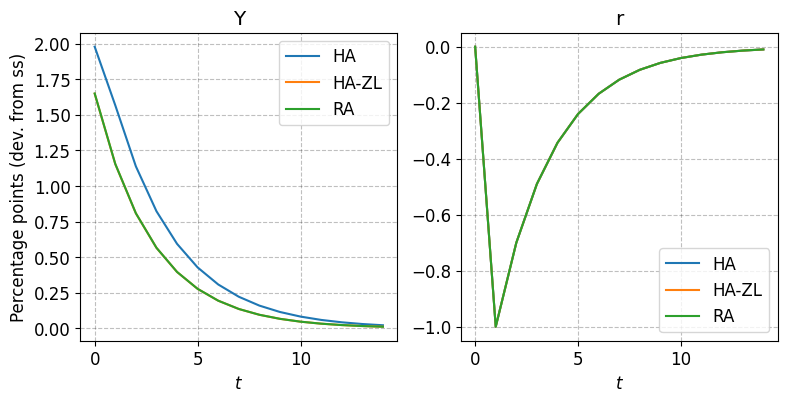

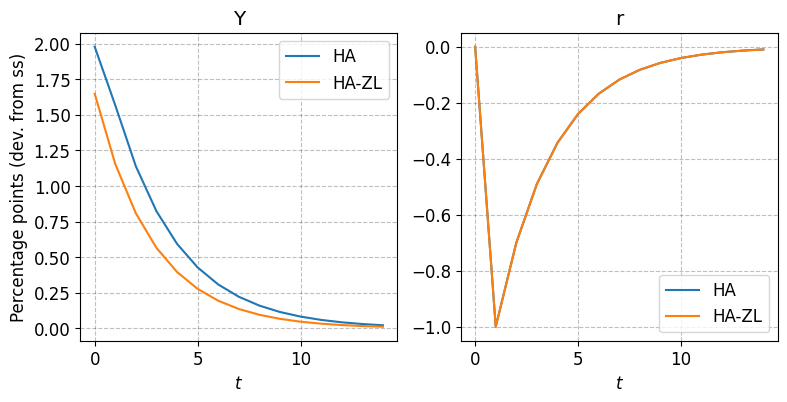

In [9]:
show_irfs([irf['ha'], irf['ha_zl'], irf['ra']], variables=['Y', 'r'], labels=['HA', 'HA-ZL', 'RA'], T_plot=15)
show_irfs([irf['ha'], irf['ha_zl']], variables=['Y', 'r'], labels=['HA', 'HA-ZL'], T_plot=15)

The baseline HA economy  has a higher output response to the interest rate shock! The RA is exactly the same as the HA with zero liquidity. 

Why? 
Recall that in a credit economy with zero liquidity all agents have $a = 0$ in equilibrium. This means that they behave just like a RA economy where the RA holds 0 net assets. Ivan Werning emphasize this result in his 2015 working paper version. Recall we have acyclical income risk, this will be important as we show later. 

To understand the higher output response in HA economies, recall that the linearized response of output implies:

$$
d \mathbb{Y} = \underbrace{\mathbb{M}^r d \mathbb{r}}_{\text{direct effects}} + \underbrace{\mathbb{M} d \mathbb{Y}}_{\text{indirect effects}}.
$$

Abusing the notation, particularly assuming some regularity conditions in $\mathbb{M}$, we have:

$$
d \mathbb{Y} =  (\mathbb{I} - \mathbb{M})^{-1} \mathbb{M}^r d \mathbb{r}.
$$

So the response depends on both $\mathbb{M}$ and $\mathbb{M}^r$.

We will now inspect the "direct" and "indirect effect" of the interest rate shock.

In [10]:
help(models['ha']['hh'].jacobian)

Help on method jacobian in module sequence_jacobian.blocks.block:

jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, inputs: List[str], outputs: Optional[List[str]] = None, T: Optional[int] = None, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.het_block.HetBlock instance
    Calculate a partial equilibrium Jacobian to a set of `input` shocks at a steady state `ss`.



Here we see that `.jacobian` takes arguments (in order):
1. `SteadyStateDict` (the output of a call to `.steady_state`, or `.solve_steady_state`),
2. a `list` of inputs the user wants to calculate the Jacobian with respect to

Now we're ready to calculate the direct effect of a change in the interest rate on consumption. 

Note that,going from the primitive `r` to the household block requires first going through the `ex_post_rate` block to get the ex-post rate from the ex-ante rate. What we really want is this combined Jacobian.

A simple way to do this is to form a `CombinedBlock`.

We can now take the Jacobian of this block with respect to its two inputs `Y` and `r_ante`.

In [11]:
ha_main = sj.combine([household_simple, ex_post_rate], name='ha_combined')
ha_main
J = ha_main['ha_combined'].jacobian(ss['ha'], inputs=['Y', 'r_ante'], T=T)
print(J)

<JacobianDict outputs=['A', 'C', 'r'], inputs=['Y', 'r_ante']>


Vizualizing the Consumption jacobians:

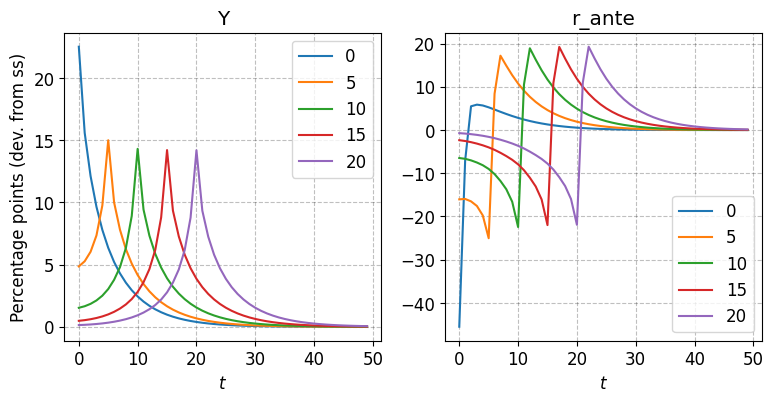

In [12]:
col_list = [0, 5, 10, 15, 20]
J_cols = [{'Y':J['C']['Y'][:, i], 'r_ante':J['C']['r_ante'][:, i]} 
          for i in col_list]


col_list = [0, 5, 10, 15, 20]
J_cols = [{'Y':J['C']['Y'][:, i], 'r_ante':J['C']['r_ante'][:, i]} \
          for i in col_list]
show_irfs(J_cols, ['Y', 'r_ante'], labels=col_list)

We can use these Jacobians to get he direct/indirect decomposition. 

In [13]:
dC, dC_dr, dC_dY = {}, {}, {}  # we include that in dictionaries since we will also do for the RA model.
dC['ha'] = irf['ha']['C']   # Total Effect
dC_dr['ha'] = J['C']['r_ante']  @ dr     # Direct Effect
dC_dY['ha'] = J['C']['Y'] @ dC['ha']     # Indirect Effect



Note that the total effect is the sum of both the direct and indirect. 
Let's test if they are actually the same:

In [14]:
np.allclose(dC_dr['ha']+dC_dY['ha'], dC['ha'])

True

Now, we'll redo the same calculations in the RA model, and then compare the direct/indirect decomposition in both models. 

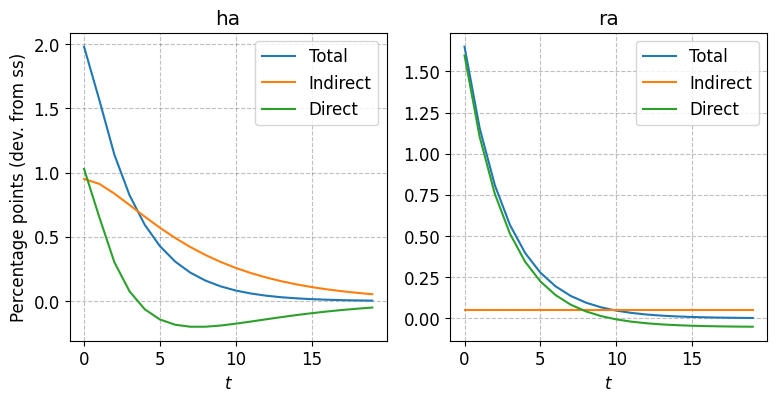

In [15]:
# Re-do the same calculations for the RA model
dC['ra'] = irf['ra']['C']

beta = calibration_ra['beta']
Mra = (1 - beta) * beta ** (np.tile(np.arange(T), (T, 1))) # recall that M in the representative agent is represent like this (see IKC paper)
dC_dY['ra'] = Mra @ dC['ra']
dC_dr['ra'] = dC['ra'] - dC_dY['ra']

show_irfs([dC, dC_dY, dC_dr], variables=['ha', 'ra'], labels=['Total', 'Indirect', 'Direct'], T_plot=20)

This was just like Kaplan-Moll-Violante. Heterogeneity reduces the direct effect (sensitivity of interest rate changes), but increases the indirect effect! 

## Cyclical income risk


Before we introduce cyclical income risk, let's look at the baseline case of an impulse response to a future, anticipated interest rate cut (forward guidance) with our baseline HA model with acyclical income risk.

A simple way to do this is to get the general equilibrium Jacobian of the model, which we obtain with `solve_jacobian`. Then, the $s$ th column of that Jacobian gives us the impulse response to a forward-guidance `r` shock at date $s$.

In [16]:
# Model jacobian in ra and ha models
T = 300
G = {}

G['ra'] = models['ra'].solve_jacobian(ss['ra'], ['Y'], ['asset_mkt'], ['r_ante'], T=T)
G['ha'] = models['ha'].solve_jacobian(ss['ha'], ['Y'], ['asset_mkt'], ['r_ante'], T=T)


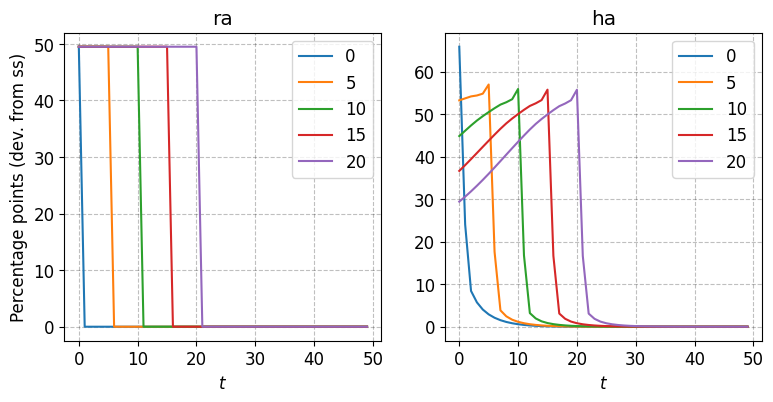

In [17]:
# select a few columns
col_list = [0, 5, 10, 15, 20]
# Interest rate shock
plot_models = ['ra', 'ha']
J_cols = [{k: -G[k]['Y']['r_ante'][:, i] for k in plot_models} for i in col_list]
show_irfs(J_cols, plot_models, labels=col_list)



The standard HA model with acyclical income risk does not solve the forward guidance puzzle. 

To go beyond this, we want to move away from income being just $e \times Y$, so that low-`e` agents are more or less sensitive to `Y`. 

To do this, we'll change the `income` hetinput. We'll use the following specification from Auclert \& Rognlie (2018)

$$ y_{it} = Y \cdot \frac{e_{it}^{1 + \zeta \log(Y)}}{\mathbb{E}[e_{it}^{1 + \zeta \log(Y)}]}$$

Note that this function implies

$$
\text{sd} (\log y_{it}) = (1 + \zeta \log Y_{it})  \text{sd} (\log e_{it})
$$

- $\zeta > 0$: procyclical inequality and income risk
- $\zeta < 0$: countercyclical inequality and income risk
- $\zeta = 0$: acyclical inequality & risk


Call this new function `income_cyclical`. 

In [18]:
def income_cyclical(Y,e_grid, e_pdf, zeta):
    y = Y * e_grid ** (1 + zeta * np.log(Y)) / np.vdot(e_grid ** (1 + zeta * np.log(Y)), e_pdf)
    return y

This `hetinput` maps `zeta`, a variable that scales the degree of cyclicality of income risk, to `y` the post-tax labor income of households. When `zeta` = 0, income risk is acyclical but when `zeta` >/< 0, income risk is pro-/counter-cyclical

Note that this function requires the pdf of `e`. Since the standard SSJ implementation of `make_grids` doesn't this to us, we rewrite it here with this extra output.

In [19]:
def make_grids_pdf(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, e_pdf, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, e_pdf, Pi, a_grid

Re-define and calibrate the model:

In [20]:
household_cyc = hh.add_hetinputs([make_grids_pdf, income_cyclical])
ha_cyc = sj.create_model([household_cyc, ex_post_rate, mkt_clearing_simple], \
                         name="HA Model with cyclical income risk")

calib_cyc = calibration.copy()
calib_cyc['zeta'] = -0.5 # Acyclical

ss['ha_cyc'] = ha_cyc.solve_steady_state(calib_cyc, {'beta': (0.75, 0.9)}, ['asset_mkt']) # find the new beta

`zeta` should not change the steady state, we check this. 

In [21]:
np.isclose(ss['ha_cyc']['beta'], ss['ha']['beta'])

True

Now we solve the model with counter-cyclical and pro-cyclical income risk and plot the Jacobians to see if this matter for the forward guidance puzzle.

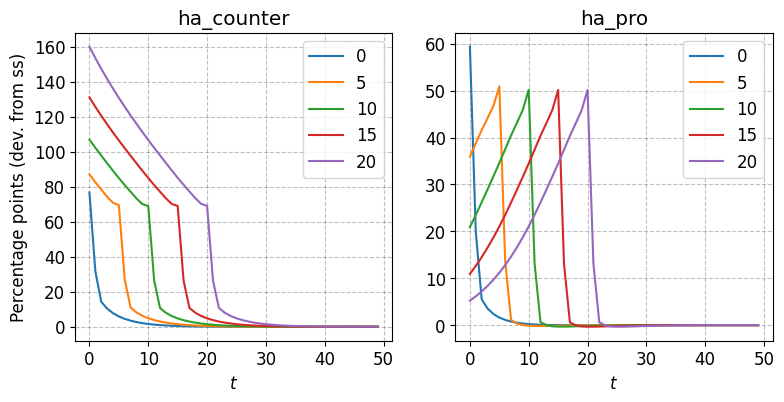

In [22]:
# Model jacobian in ha models with cyclical risk
for zeta, mod in zip([-0.5, 0.5], ['ha_counter', 'ha_pro']):
    ss_cyc = ss['ha_cyc'].copy()
    ss_cyc['zeta'] = zeta    # income risk does not change the steady state
    G[mod] = ha_cyc.solve_jacobian(ss_cyc, ['Y'], ['asset_mkt'], ['r_ante'], T=T)


col_list = [0, 5, 10, 15, 20]
plot_models = ['ha_counter', 'ha_pro']
J_cols = [{k: -G[k]['Y']['r_ante'][:, i] for k in plot_models} for i in col_list]
show_irfs(J_cols, plot_models, labels=col_list)

Result: Cyclical income risk matters
- Procyclical income risk $\Rightarrow$ weakens monetary policy + fwd guidance but not empirically supported.
- Countercyclical income risk is empirically more plausible, but aggravates forward guidance puzzle!

You have to be careful with your model because there are many elements that create indirect procyclical income rik in your models.

Recall that agents receive also:
- taxes
- dividends from firms

both taxes (if balanced budget) and dividends fall after expansionary $r$ (if sticky prices not sticky wages). These are the assumptions in McKay et al (2016) and onde of the reasons why that paper “solves” the forward guidance puzzle!